In [1]:
import os
import requests
from zipfile import ZipFile
from urllib.request import urlretrieve
import pandas as pd
import numpy as np
#import altair as alt
#from vega_datasets import data
%matplotlib inline
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import statsmodels.api as sm
from sklearn.feature_selection import RFECV
from sklearn.ensemble import *
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.model_selection import *
from sklearn.metrics import *
from pycaret.classification import *
from imblearn.over_sampling import SMOTE
from sklearn.inspection import permutation_importance
import re
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline


In [2]:
train_df = pd.read_csv(r'\Users\tegan\OneDrive\Desktop\Milestone2\train_df')
test_df = pd.read_csv(r'\Users\tegan\OneDrive\Desktop\Milestone2\test_df')

train_df_std = pd.read_csv(r'\Users\tegan\OneDrive\Desktop\Milestone2\train_df_std')
test_df_std = pd.read_csv(r'\Users\tegan\OneDrive\Desktop\Milestone2\test_df_std')

In [3]:
X_train, y_train = train_df.drop('Cancer', axis=1), train_df.Cancer
X_test, y_test = test_df.drop('Cancer', axis=1), test_df.Cancer

X_train_std, y_train_std = train_df_std.drop('Cancer', axis=1), train_df_std.Cancer
X_test_std, y_test_std = test_df_std.drop('Cancer', axis=1), test_df_std.Cancer

In [4]:
def create_plot(model, params, title, xlabel):
    recalls = []
    recall_stds = []
    precs = []
    prec_stds = []
    accs = []
    acc_stds = []
    f1s = []
    f1_stds = []

    for i in range(len(params)):
        recalls.append(np.round(model.cv_results_['mean_test_recall'][i], 4))
        recall_stds.append(np.round(model.cv_results_['std_test_recall'][i], 4))
        precs.append(np.round(model.cv_results_['mean_test_precision'][i], 4))
        prec_stds.append(np.round(model.cv_results_['std_test_precision'][i], 4))
        f1s.append(np.round(model.cv_results_['mean_test_f1'][i], 4))
        f1_stds.append(np.round(model.cv_results_['std_test_f1'][i], 4))
        accs.append(np.round(model.cv_results_['mean_test_accuracy'][i], 4))
        acc_stds.append(np.round(model.cv_results_['std_test_accuracy'][i], 4))

    recall_upper = np.round([x + y for x, y in zip(recalls, recall_stds)], 4)
    recall_lower = np.round([x - y for x, y in zip(recalls, recall_stds)], 4)

    prec_upper = np.round([x + y for x, y in zip(precs, recall_stds)], 4)
    prec_lower = np.round([x - y for x, y in zip(precs, recall_stds)], 4)

    f1_upper = np.round([x + y for x, y in zip(f1s, recall_stds)], 4)
    f1_lower = np.round([x - y for x, y in zip(f1s, recall_stds)], 4)

    acc_upper = np.round([x + y for x, y in zip(accs, recall_stds)], 4)
    acc_lower = np.round([x - y for x, y in zip(accs, recall_stds)], 4)



    plt.figure(figsize=(10, 6))
    plt.plot(params, recalls, marker='o', label='Recall')
    plt.fill_between(params, recall_lower, recall_upper, color='blue', alpha=0.3)
    plt.plot(params, precs, marker='o', label='Precision')
    plt.fill_between(params, prec_lower, prec_upper, color='orange', alpha=0.3)
    plt.plot(params, accs, marker='o', label='Accuracy')
    plt.fill_between(params, acc_lower, acc_upper, color='green', alpha=0.3)
    plt.plot(params, f1s, marker='o', label='F1')
    plt.fill_between(params, f1_lower, f1_upper, color='red', alpha=0.3)
    plt.xlabel(xlabel)
    plt.ylabel('Performance')
    plt.yticks(np.arange(0, 1.1, step=0.1))
    plt.title(title)

    plt.legend(bbox_to_anchor=(1.15, 1), loc='upper right', borderaxespad=0.)
    plt.tight_layout() 
    plt.style.use('default')
    plt.show()

In [5]:
#Column Transformer
cols_to_std=['Age Group','Num of Bad Mental Health Days','Years Since Last Checkup','Hours of Sleeping','Age Started Smoking',
 'Cigarettes per Day','Days Drinking','Income','BMI']

ct = ColumnTransformer([('std',StandardScaler(),cols_to_std)])


# NB pipeline
nb_pipeline = Pipeline([
    ('ct', ct),
    ('smote', SMOTE(random_state=42)),  
    ('nb', GaussianNB())
])

# NB Parameter Grid
param_grid = {
    'nb__var_smoothing': np.arange(0, 4.1, step=0.2),
}

# Grid search
grid_search = GridSearchCV(estimator=nb_pipeline, param_grid=param_grid, cv=5, scoring=['recall','precision','f1','accuracy'],refit='recall')
nb_var = grid_search.fit(X_train, y_train)



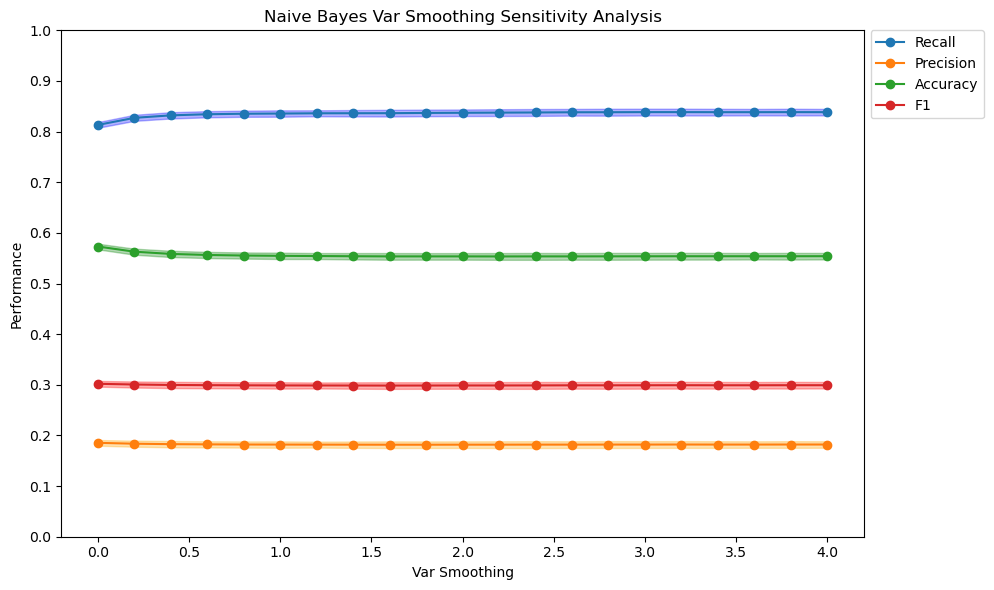

In [7]:
create_plot(params=param_grid['nb__var_smoothing'], model=nb_var, title="Naive Bayes Var Smoothing Sensitivity Analysis", xlabel='Var Smoothing')

# SGDC

In [8]:
#Column Transformer
cols_to_std=['Age Group','Num of Bad Mental Health Days','Years Since Last Checkup','Hours of Sleeping','Age Started Smoking',
 'Cigarettes per Day','Days Drinking','Income','BMI']

ct = ColumnTransformer([('std',StandardScaler(),cols_to_std)])


# sgdc pipelinewq2321
sgdc_pipeline = Pipeline([
    ('ct', ct),
    ('smote', SMOTE(random_state=42)),  
    ('sgdc', SGDClassifier())
])

# sgdc Parameter Grid 
# Note: more values have been tested than what is shown, small amounts of values were run at a time to increase runtime.
param_grid = {
    'sgdc__loss': ['hinge'], #using only hinge loss in order to implement SVM
    'sgdc__penalty': ['l2'],
    'sgdc__learning_rate': ['adaptive'],
    'sgdc__alpha': [0, .25, .5, .75, 1, 1.25, 1.5, 1.75, 2],
    'sgdc__eta0': [0.025]
}

# Grid search
grid_search = GridSearchCV(estimator=sgdc_pipeline, param_grid=param_grid, cv=5, scoring=['recall','precision','f1','accuracy'],refit='recall')
sgdc_alpha = grid_search.fit(X_train, y_train)
    


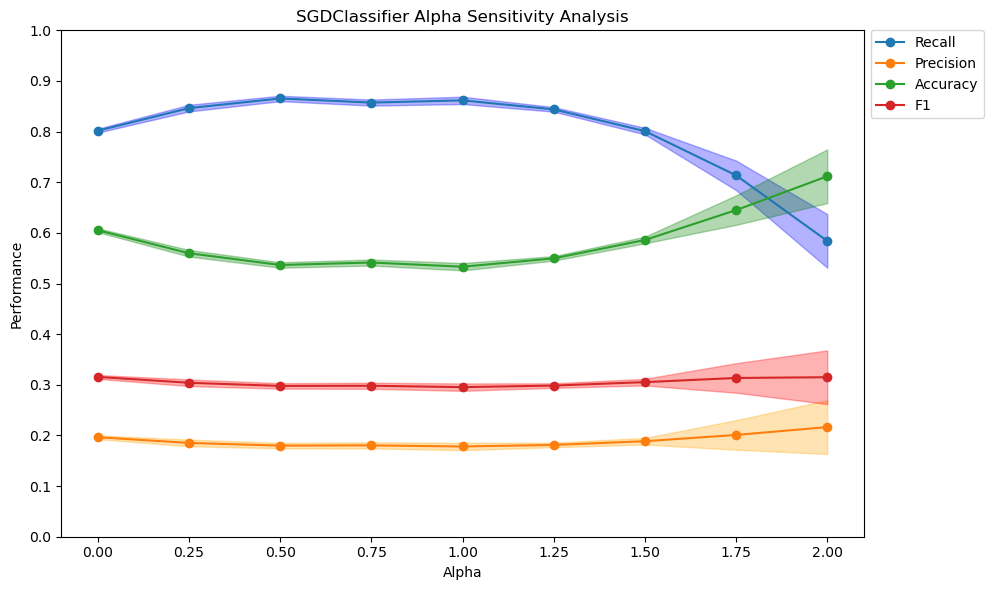

In [9]:
create_plot(params=param_grid['sgdc__alpha'], model=sgdc_alpha,title="SGDClassifier Alpha Sensitivity Analysis", xlabel='Alpha')

In [103]:
#Column Transformer
cols_to_std=['Age Group','Num of Bad Mental Health Days','Years Since Last Checkup','Hours of Sleeping','Age Started Smoking',
 'Cigarettes per Day','Days Drinking','Income','BMI']

ct = ColumnTransformer([('std',StandardScaler(),cols_to_std)])


# sgdc pipeline
sgdc_pipeline = Pipeline([
    ('ct', ct),
    ('smote', SMOTE(random_state=42)),  
    ('sgdc', SGDClassifier())
])

# sgdc Parameter Grid 
# Note: more values have been tested than what is shown, small amounts of values were run at a time to increase runtime.
param_grid = {
    'sgdc__loss': ['hinge'], #using only hinge loss in order to implement SVM
    'sgdc__penalty': ['l2'],
    'sgdc__learning_rate': ['adaptive'],
    'sgdc__alpha': [0.5],
    'sgdc__eta0': [0, .25, .5, .75, 1, 1.25, 1.5, 1.75, 2]
}

# Grid search
grid_search = GridSearchCV(estimator=sgdc_pipeline, param_grid=param_grid, cv=5, scoring=['recall','precision','f1','accuracy'],refit='recall')
sgdc_eta0 = grid_search.fit(X_train, y_train)

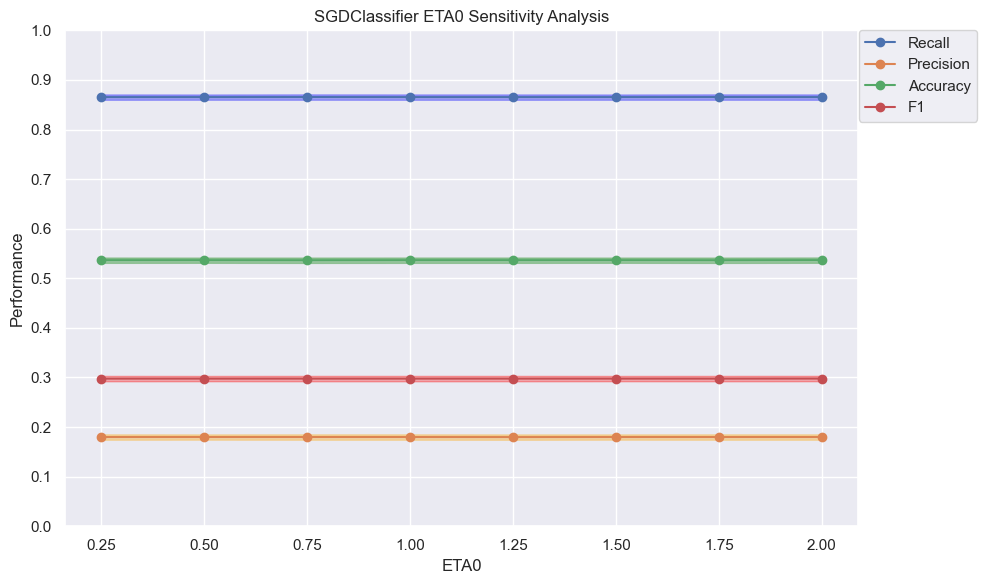

In [106]:
create_plot(params=param_grid['sgdc__eta0'], model=sgdc_eta0, title="SGDClassifier ETA0 Sensitivity Analysis", xlabel='ETA0')

In [107]:
#Column Transformer
cols_to_std=['Age Group','Num of Bad Mental Health Days','Years Since Last Checkup','Hours of Sleeping','Age Started Smoking',
 'Cigarettes per Day','Days Drinking','Income','BMI']

ct = ColumnTransformer([('std',StandardScaler(),cols_to_std)])


# sgdc pipelinewq2321
sgdc_pipeline = Pipeline([
    ('ct', ct),
    ('smote', SMOTE(random_state=42)),  
    ('sgdc', SGDClassifier())
])

# sgdc Parameter Grid 
# Note: more values have been tested than what is shown, small amounts of values were run at a time to increase runtime.
param_grid = {
    'sgdc__loss': ['hinge'], #using only hinge loss in order to implement SVM
    'sgdc__penalty': ['l2'],
    'sgdc__learning_rate': ['adaptive'],
    'sgdc__alpha': [0.5],
    'sgdc__eta0': [0.025],
    'sgdc__power_t': [0.1, 0.25, 0.5, 0.75, 1.0]
}

# Grid search
grid_search = GridSearchCV(estimator=sgdc_pipeline, param_grid=param_grid, cv=5, scoring=['recall','precision','f1','accuracy'],refit='recall')
sgdc_power_t = grid_search.fit(X_train, y_train)
    


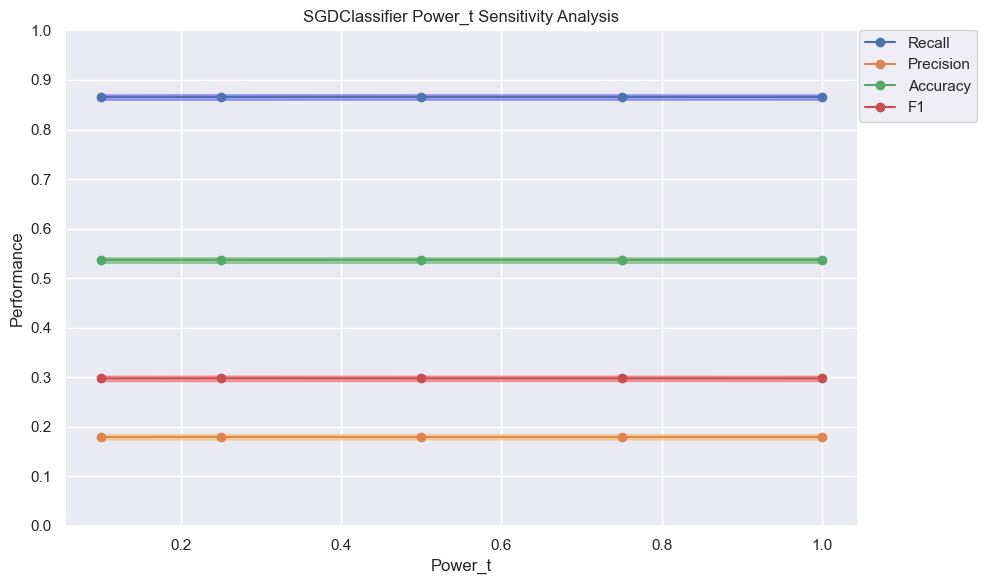

In [109]:
create_plot(params=param_grid['sgdc__power_t'], model=sgdc_power_t, title="SGDClassifier Power_t Sensitivity Analysis", xlabel='Power_t')

 # Random Forest

In [10]:
#Column Transformer
cols_to_std=['Age Group','Num of Bad Mental Health Days','Years Since Last Checkup','Hours of Sleeping','Age Started Smoking',
 'Cigarettes per Day','Days Drinking','Income','BMI']

ct = ColumnTransformer([('std',StandardScaler(),cols_to_std)])


# rfc pipeline
rfc_pipeline = Pipeline([
    ('ct', ct),
    ('smote', SMOTE(random_state=42)),  
    ('rfc', RandomForestClassifier())
])

# sgdc Parameter Grid  
# Note: more values have been tested than what is shown, small amounts of values were run at a time to increase runtime.
param_grid = {
    'rfc__n_estimators': [30],
    'rfc__criterion': ['gini'], #using gini to optimize run time
    'rfc__max_depth': [1, 3, 5, 10, 15, 20],
    'rfc__min_samples_split': [2],
    'rfc__min_samples_leaf': [2],
    'rfc__random_state': [42]
}

# Grid search
grid_search = GridSearchCV(estimator=rfc_pipeline, param_grid=param_grid, cv=5, scoring=['recall','precision','f1','accuracy'],refit='recall')
rfc_depth = grid_search.fit(X_train, y_train)

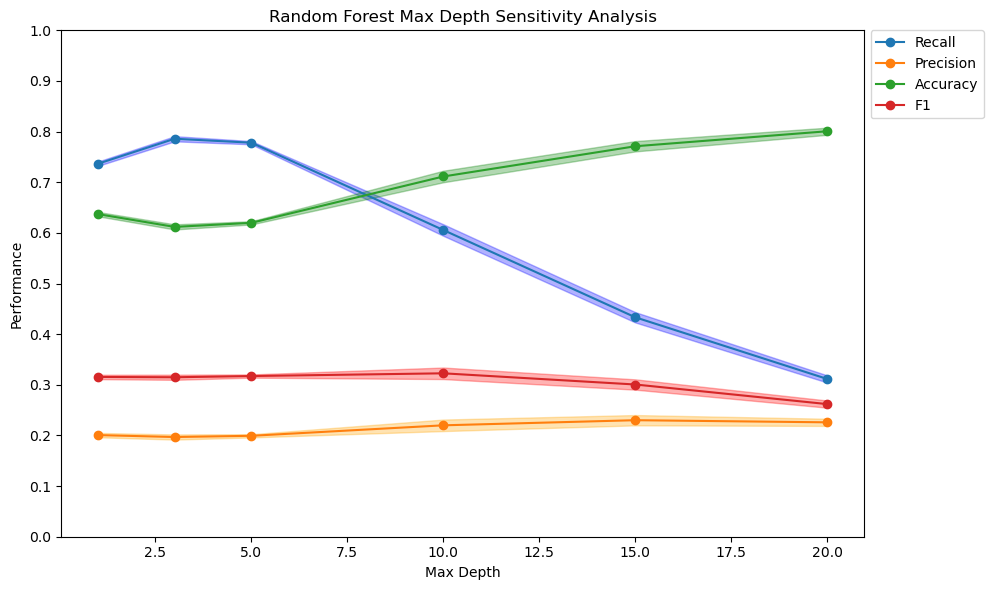

In [11]:
create_plot(params=param_grid['rfc__max_depth'], model=rfc_depth, title='Random Forest Max Depth Sensitivity Analysis', xlabel='Max Depth')

In [112]:
#Column Transformer
cols_to_std=['Age Group','Num of Bad Mental Health Days','Years Since Last Checkup','Hours of Sleeping','Age Started Smoking',
 'Cigarettes per Day','Days Drinking','Income','BMI']

ct = ColumnTransformer([('std',StandardScaler(),cols_to_std)])


# rfc pipeline
rfc_pipeline = Pipeline([
    ('ct', ct),
    ('smote', SMOTE(random_state=42)),  
    ('rfc', RandomForestClassifier())
])

# sgdc Parameter Grid  
# Note: more values have been tested than what is shown, small amounts of values were run at a time to increase runtime.
param_grid = {
    'rfc__n_estimators': [30],
    'rfc__criterion': ['gini'], #using gini to optimize run time
    'rfc__max_depth': [3],
    'rfc__min_samples_split': [2, 5, 10],
    'rfc__min_samples_leaf': [2],
    'rfc__random_state': [42]
}

# Grid search
grid_search = GridSearchCV(estimator=rfc_pipeline, param_grid=param_grid, cv=5, scoring=['recall','precision','f1','accuracy'],refit='recall')
rfc_split = grid_search.fit(X_train, y_train)

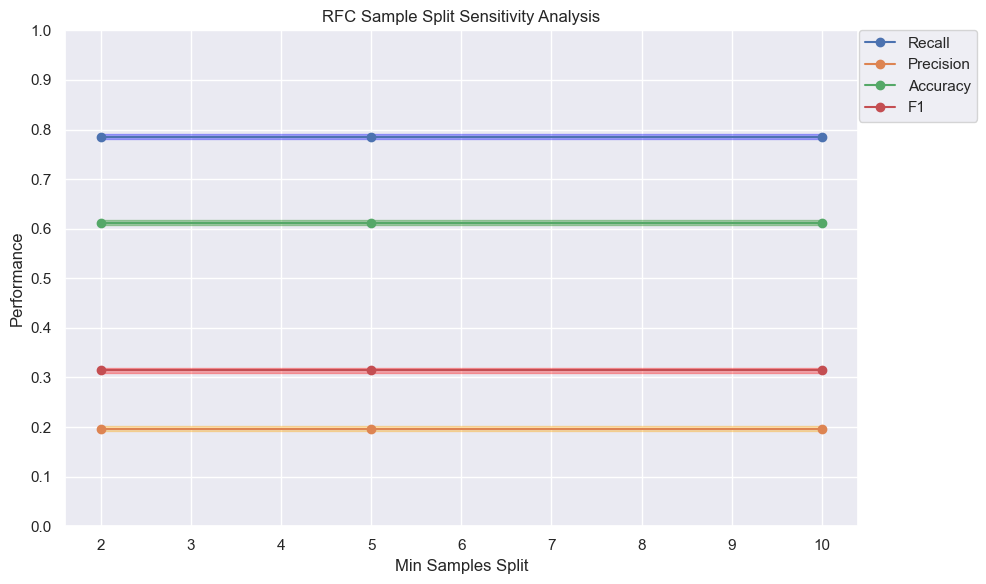

In [113]:
create_plot(params=param_grid['rfc__min_samples_split'], model=rfc_split, title="RFC Sample Split Sensitivity Analysis", xlabel="Min Samples Split")

In [121]:
#Column Transformer
cols_to_std=['Age Group','Num of Bad Mental Health Days','Years Since Last Checkup','Hours of Sleeping','Age Started Smoking',
 'Cigarettes per Day','Days Drinking','Income','BMI']

ct = ColumnTransformer([('std',StandardScaler(),cols_to_std)])


# rfc pipeline
rfc_pipeline = Pipeline([
    ('ct', ct),
    ('smote', SMOTE(random_state=42)),  
    ('rfc', RandomForestClassifier())
])

# sgdc Parameter Grid  
# Note: more values have been tested than what is shown, small amounts of values were run at a time to increase runtime.
param_grid = {
    'rfc__n_estimators': [30],
    'rfc__criterion': ['gini'], #using gini to optimize run time
    'rfc__max_depth': [3],
    'rfc__min_samples_split': [2],
    'rfc__min_samples_leaf': [1, 2, 4],
    'rfc__random_state': [42]
}

# Grid search
grid_search = GridSearchCV(estimator=rfc_pipeline, param_grid=param_grid, cv=5, scoring=['recall','precision','f1','accuracy'],refit='recall')
rfc_leaf = grid_search.fit(X_train, y_train)

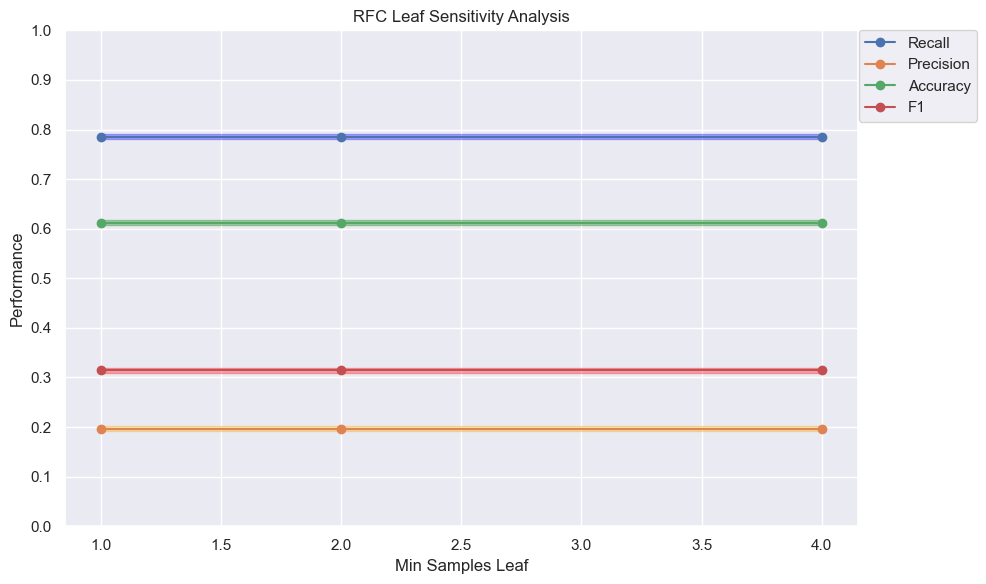

In [122]:
create_plot(params=param_grid['rfc__min_samples_leaf'], model=rfc_leaf, title="RFC Leaf Sensitivity Analysis", xlabel="Min Samples Leaf")

In [115]:
#Column Transformer
cols_to_std=['Age Group','Num of Bad Mental Health Days','Years Since Last Checkup','Hours of Sleeping','Age Started Smoking',
 'Cigarettes per Day','Days Drinking','Income','BMI']

ct = ColumnTransformer([('std',StandardScaler(),cols_to_std)])


# rfc pipeline
rfc_pipeline = Pipeline([
    ('ct', ct),
    ('smote', SMOTE(random_state=42)),  
    ('rfc', RandomForestClassifier())
])

# sgdc Parameter Grid  
# Note: more values have been tested than what is shown, small amounts of values were run at a time to increase runtime.
param_grid = {
    'rfc__n_estimators': [10, 30, 100, 300, 500],
    'rfc__criterion': ['gini'], #using gini to optimize run time
    'rfc__max_depth': [3],
    'rfc__min_samples_split': [2],
    'rfc__min_samples_leaf': [2],
    'rfc__random_state': [42]
}

# Grid search
grid_search = GridSearchCV(estimator=rfc_pipeline, param_grid=param_grid, cv=5, scoring=['recall','precision','f1','accuracy'],refit='recall')
rfc_est = grid_search.fit(X_train, y_train)

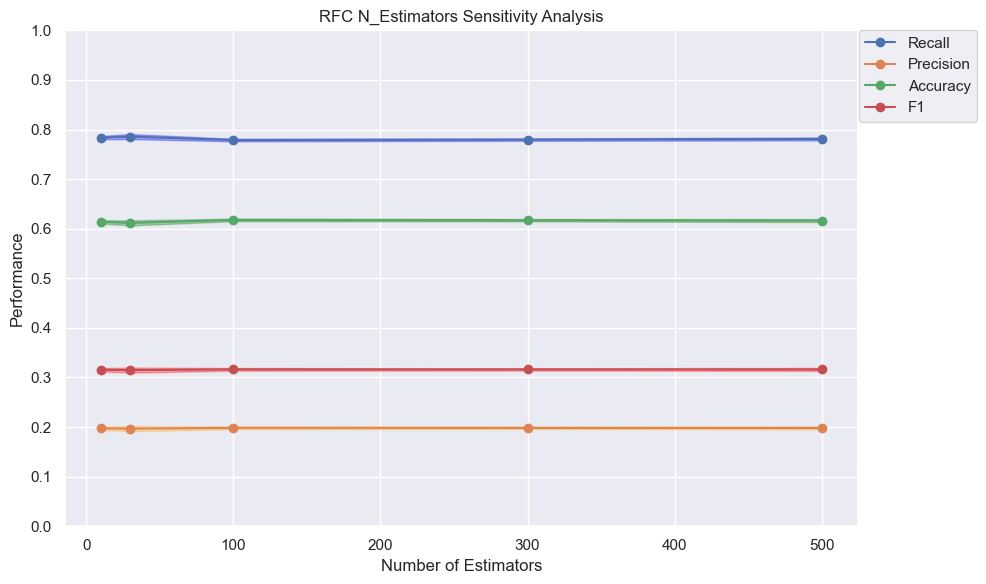

In [118]:
create_plot(params=param_grid['rfc__n_estimators'], model=rfc_est, title="RFC N_Estimators Sensitivity Analysis", xlabel="Number of Estimators")